Advanced sequencing
================

In this tutorial we will demonstrate advanced sequencer based operations, where we focus on waveform parametrization (see section [Sequencer](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/documentation/sequencer.html)). We will demonstrate this by creating a sequence that will show various sequencer features, 
including complex looping constructs, dynamic gain control, hardware-based modulation and marker output control.

The sequence itself will use four waveform envelopes with a duration of 1μs each; a gaussian, a sine, a sawtooth and a block. We will have several nested loops
in the sequence. The first loop will increase the wait period between the start of the iteration and playback of the waveform envelope and also increase the gain of
the waveform envelope on every iteration. At the end of this loop a second loop will do the inverse operations. A third loop will loop over the first and
second loops to iterate over the four waveform envelopes. And finally a fourth loop will function as an infinite loop over the third loop.
At the same time, the sequence will also control marker output 1 and create a trigger point at the start of each iteration of the first and second loops as well an
"enable" during playback. Finally, each waveform envelope will be modulated at 10MHz.

The result of this sequence, when observed on an oscilloscope, will be iterating waveform envelopes that will be sliding over the modulation frequency with varying gain,
encapsulated by an "enable" on the marker output. We highly recommend that you take a look at it, to get an impression of what is possible with the sequencers.

Setup
-----

First, we are going to import the required packages and connect to the instrument.

In [1]:
#Set up the environment.
import scipy.signal
import math
import json
import matplotlib.pyplot
import numpy

from qblox_instruments import Pulsar

#Close any existing connections to any Pulsar.
Pulsar.close_all()

#Connect to the Pulsar at default IP address.
pulsar = Pulsar("pulsar", "192.168.0.2")

#Reset the instrument for good measure.
pulsar.reset()
print("Status:")
print(pulsar.get_system_state())

Status:
SystemState(status=<SystemStatus.OKAY: 2>, flags=[])


Generate waveforms
------------------

Next, we need to create the gaussian, sine, sawtooth and block waveform envelopes for the sequence.

In [2]:
#Waveform parameters
waveform_length = 1000 #nanoseconds

#Waveform dictionary (data will hold the samples and index will be used to select the waveforms in the instrument).
waveforms = {
                "gaussian": {"data": scipy.signal.gaussian(waveform_length, std=0.12 * waveform_length).tolist(),         "index": 0},
                "sine":     {"data": [math.sin((2 * math.pi / waveform_length) * i ) for i in range(0, waveform_length)], "index": 1},
                "sawtooth": {"data": [(1.0 / (waveform_length)) * i for i in range(0, waveform_length)],                  "index": 2},
                "block":    {"data": [1.0 for i in range(0, waveform_length)],                                            "index": 3}
            }    

Let's plot the waveforms to see what we have created.

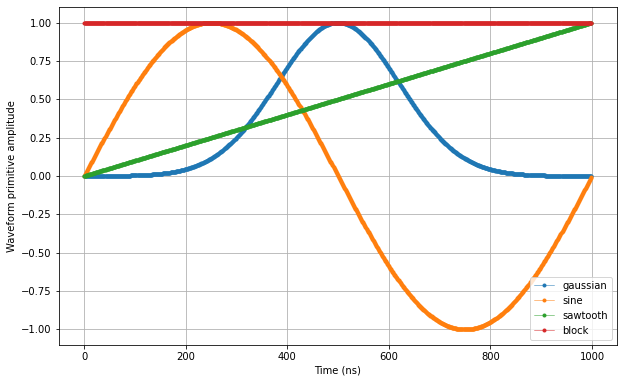

In [3]:
time    = numpy.arange(0, max(map(lambda d: len(d["data"]), waveforms.values())), 1)
fig, ax = matplotlib.pyplot.subplots(1,1, figsize=(10, 10/1.61))

for wf, d in waveforms.items():
    ax.plot(time[:len(d["data"])], d["data"], ".-", linewidth=0.5, label=wf)

ax.legend(loc=4)
ax.yaxis.grid()
ax.xaxis.grid()
ax.set_ylabel("Waveform primitive amplitude")
ax.set_xlabel("Time (ns)")

matplotlib.pyplot.draw()
matplotlib.pyplot.show()

Create Q1ASM program
--------------------

Now that we have the waveforms for the sequence, we need a Q1ASM program that sequences the waveforms as previously described.

In [4]:
#Sequence program.
seq_prog = """
                  wait_sync    4                    #Wait for synchronization
                  reset_ph                          #Reset absolute phase
                  upd_param    4                    #Update all parameters and wait 4ns
start:            move         4,R0                 #Init number of waveforms
                  move         0,R1                 #Init waveform index

mult_wave_loop:   move         166,R2               #Init number of single wave loops (increasing wait)
                  move         166,R3               #Init number of single wave loops (decreasing wait)
                  move         24,R4                #Init number of dynamic wait time (total of 4us)
                  move         3976,R5              #Init number of dynamic wait time remainder
                  move         32768,R6             #Init gain (Maximum gain)

sngl_wave_loop_0: move         800,R7               #Init number of long wait loops (total of 40ms)
                  set_mrk      15                   #Set marker to 0xF
                  upd_param    4                    #Update all parameters and wait 4ns
                  set_mrk      0                    #Set marker to 0
                  upd_param    96                   #Update all parameters and wait 96ns

                  wait         R4                   #Dynamic wait
                  add          R4,24,R4             #Increase wait

                  set_mrk      1                    #Set marker to 1
                  play         R1,R1,996            #Play waveform and wait 996ns
                  set_mrk      0                    #Set marker to 0
                  upd_param    4                    #Update all parameters and wait for 4ns

                  wait         R5                   #Compensate previous dynamic wait
                  sub          R5,24,R5             #Decrease wait

                  sub          R6,98,R6             #Decrease gain
                  nop
                  set_awg_gain R6,R6                #Set gain

long_wait_loop_0: wait         50000                #Wait 50 us
                  loop         R7,@long_wait_loop_0 #Wait total of 40ms
                  loop         R2,@sngl_wave_loop_0 #Repeat single wave loop

sngl_wave_loop_1: move         800,R7               #Init number of long wait loops (total of 40ms)
                  set_mrk      15                   #Set marker to 0xF
                  upd_param    8                    #Update all parameters and wait 8ns
                  set_mrk      0                    #Set marker to 0
                  upd_param    92                   #Update all parameters and wait 92ns

                  wait         R4                   #Dynamic wait
                  sub          R4,24,R4             #Decrease wait

                  set_mrk      1                    #Set marker to 1
                  play         R1,R1,996            #Play waveform and wait 996ns
                  set_mrk      0                    #Set marker to 0
                  upd_param    4                    #Update all parameters and wait 4ns

                  wait         R5                   #Compensate previous dynamic wait
                  add          R5,24,R5             #Increase wait

                  sub          R6,98,R6             #Decrease gain
                  nop
                  set_awg_gain R6,R6                #Set gain

long_wait_loop_1: wait         50000                #Wait for 50 us
                  loop         R7,@long_wait_loop_1 #Wait total of 40ms
                  loop         R3,@sngl_wave_loop_1 #Repeat single wave loop

                  add          R1,1,R1              #Adjust waveform index
                  loop         R0,@mult_wave_loop   #Repeat with next waveform envelope
                  jmp          @start               #Repeat entire sequence
"""

Upload sequence
---------------

Now that we have the waveforms and Q1ASM program, we can combine them in a sequence stored in a JSON file.

In [5]:
#Add sequence to single dictionary and write to JSON file.
seqeunce = {"waveforms": waveforms, "weights": {}, "acquisitions": {}, "program": seq_prog}
with open("sequence.json", 'w', encoding='utf-8') as file:
    json.dump(seqeunce, file, indent=4)
    file.close()

Let's write the JSON file to the instruments. We will use sequencer 0 and 1, which will drive outputs $\text{O}^{[1-2]}$ and $\text{O}^{[3-4]}$ respectively.

In [6]:
#Upload sequence.
pulsar.sequencer0.sequence("sequence.json")
pulsar.sequencer1.sequence("sequence.json")

Play sequence
-------------

The sequence has been uploaded to the instrument. Now we need to configure the sequencers in the instrument to use the `wait_sync` instruction
at the start of the Q1ASM program to synchronize and to enable the hardware-based modulation at 10MHz.

In [7]:
#Configure the sequencers to synchronize and enable modulation at 10MHz.
pulsar.sequencer0.sync_en(True)
pulsar.sequencer0.mod_en_awg(True)
pulsar.sequencer0.nco_freq(10e6)
pulsar.sequencer1.sync_en(True)
pulsar.sequencer1.mod_en_awg(True)
pulsar.sequencer1.nco_freq(10e6)

#Map sequencers to specific outputs (but first disable all sequencer connections).
for sequencer in pulsar.sequencers:
    for out in range(0, 4):
        if hasattr(sequencer, "channel_map_path{}_out{}_en".format(out%2, out)):
            sequencer.set("channel_map_path{}_out{}_en".format(out%2, out), False)

#If it is a QRM, we only map sequencer 0 to the outputs.
pulsar.sequencer0.channel_map_path0_out0_en(True)
pulsar.sequencer0.channel_map_path1_out1_en(True)
if pulsar.is_qcm_type:
    pulsar.sequencer1.channel_map_path0_out2_en(True)
    pulsar.sequencer1.channel_map_path1_out3_en(True)

Now let's start the sequence. If you want to observe the sequence, this is the time to connect an oscilloscope to marker output 1 and one or more
of the four outputs. Configure the oscilloscope to trigger on marker output 1.

In [8]:
#Arm and start sequencers.
pulsar.arm_sequencer(0)
pulsar.arm_sequencer(1)
pulsar.start_sequencer()

#Print status of sequencers.
print("Status:")
print(pulsar.get_sequencer_state(0))
print(pulsar.get_sequencer_state(1))

Status:
SequencerState(status=<SequencerStatus.RUNNING: 3>, flags=[])
SequencerState(status=<SequencerStatus.RUNNING: 3>, flags=[])


Before we continue, have you looked at the oscilloscope? Pretty nifty right? This is just an example. Imagine what else you can do with the power of
the sequencers to control and/or speed up your experiments.

Stop
----

Finally, let's stop the sequencers if they haven't already and close the instrument connection.

In [9]:
#Stop both sequencers.
pulsar.stop_sequencer()
    
#Print status of both sequencers (should now say it is stopped).
print("Status:")
print(pulsar.get_sequencer_state(0))
print(pulsar.get_sequencer_state(1))
print()

#Print an overview of the instrument parameters.
print("Snapshot:")
pulsar.print_readable_snapshot(update=True)
    
#Close the instrument connection.
pulsar.close()

Status:
SequencerState(status=<SequencerStatus.STOPPED: 5>, flags=[<SequencerStatusFlags.FORCED_STOP: 2>])
SequencerState(status=<SequencerStatus.STOPPED: 5>, flags=[<SequencerStatusFlags.FORCED_STOP: 2>])

Snapshot:
pulsar:
	parameter                    value
--------------------------------------------------------------------------------
IDN                           :	{'manufacturer': 'qblox', 'model': 'pulsar_qr...
in0_gain                      :	-6 (dB)
in1_gain                      :	-6 (dB)
out0_offset                   :	0 (V)
out1_offset                   :	0 (V)
reference_source              :	internal 
scope_acq_avg_mode_en_path0   :	False 
scope_acq_avg_mode_en_path1   :	False 
scope_acq_sequencer_select    :	0 
scope_acq_trigger_level_path0 :	0 
scope_acq_trigger_level_path1 :	0 
scope_acq_trigger_mode_path0  :	sequencer 
scope_acq_trigger_mode_path1  :	sequencer 
pulsar_sequencer0:
	parameter                       value
----------------------------------------------------